<a href="https://colab.research.google.com/github/jbeen2/Today-I-Learned/blob/main/2020-2-DataAnalysis-II/1209_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil 
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 48kB/s 


In [ ]:
import tensorflow as tf
tf.__version__

'2.3.1'

In [ ]:
from tensorflow import keras 
keras.__version__

'2.4.0'

In [ ]:
from keras.models import Sequential, Model, load_model
from keras.optimizers import SGD
from keras.layers import BatchNormalization, Lambda, Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, Reshape, Activation, Concatenate, Add
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import keras.backend as K

# Data Load 

In [ ]:
cd /content/drive/MyDrive/Stat/2020-2-DataAnalysis/Image

/content/drive/MyDrive/Stat/2020-2-DataAnalysis/Image


In [ ]:
training_images = {category: [] for category in os.listdir(os.path.join('train/'))}
testing_images = []

labels = {ix: category for ix, category in enumerate(list(training_images.keys()))}

In [ ]:
labels

{0: 'red',
 1: 'white',
 2: 'green',
 3: 'pink',
 4: 'yellow',
 5: 'silver',
 6: 'blue',
 7: 'purple',
 8: 'grey',
 9: 'brown',
 10: 'black',
 11: 'orange'}

# Modeling

In [ ]:
def color_net(num_classes):
    # placeholder for input image
    input_image = Input(shape=(224,224,3))


    # ============================================= TOP BRANCH ===================================================
    # first top convolution layer
    top_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input_image)
    top_conv1 = BatchNormalization()(top_conv1)
    top_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_conv1)

    # second top convolution layer
    # split feature map by half
    top_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(top_conv1)
    top_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(top_conv1)

    top_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv2)
    top_top_conv2 = BatchNormalization()(top_top_conv2)
    top_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv2)

    top_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv2)
    top_bot_conv2 = BatchNormalization()(top_bot_conv2)
    top_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv2)

    # third top convolution layer
    # concat 2 feature map
    top_conv3 = Concatenate()([top_top_conv2,top_bot_conv2])
    top_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_conv3)
   
    # fourth top convolution layer
    # split feature map by half
    top_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(top_conv3)
    top_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(top_conv3)

    top_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)

    # fifth top convolution layer
    top_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv5) 

    top_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)
    top_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv5)


    # ============================================= TOP BOTTOM ===================================================
    # first bottom convolution layer
    bottom_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(227,227,3),activation='relu')(input_image)
    bottom_conv1 = BatchNormalization()(bottom_conv1)
    bottom_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_conv1)

    # second bottom convolution layer
    # split feature map by half
    bottom_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(bottom_conv1)
    bottom_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(bottom_conv1)

    bottom_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv2)
    bottom_top_conv2 = BatchNormalization()(bottom_top_conv2)
    bottom_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv2)

    bottom_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv2)
    bottom_bot_conv2 = BatchNormalization()(bottom_bot_conv2)
    bottom_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv2)

    # third bottom convolution layer
    # concat 2 feature map
    bottom_conv3 = Concatenate()([bottom_top_conv2,bottom_bot_conv2])
    bottom_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_conv3)

    # fourth bottom convolution layer
    # split feature map by half
    bottom_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(bottom_conv3)
    bottom_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(bottom_conv3)

    bottom_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)

    # fifth bottom convolution layer
    bottom_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv5) 

    bottom_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)
    bottom_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv5)


    # ======================================== CONCATENATE TOP AND BOTTOM BRANCH =================================
    conv_output = Concatenate()([top_top_conv5,top_bot_conv5,bottom_top_conv5,bottom_bot_conv5])

    # Flatten
    flatten = Flatten()(conv_output)

    # Fully-connected layer
    FC_1 = Dense(units=4096, activation='relu')(flatten)
    FC_1 = Dropout(0.6)(FC_1)
    FC_2 = Dense(units=4096, activation='relu')(FC_1)
    FC_2 = Dropout(0.6)(FC_2)
    output = Dense(units=num_classes, activation='softmax')(FC_2)
    
    model = Model(inputs=input_image, outputs=output)
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
num_classes = 12

In [ ]:
model = color_net(num_classes)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 54, 54, 48)   17472       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 54, 54, 48)   17472       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 54, 54, 48)   192         conv2d[0][0]                     
_______________________________________________________________________________________

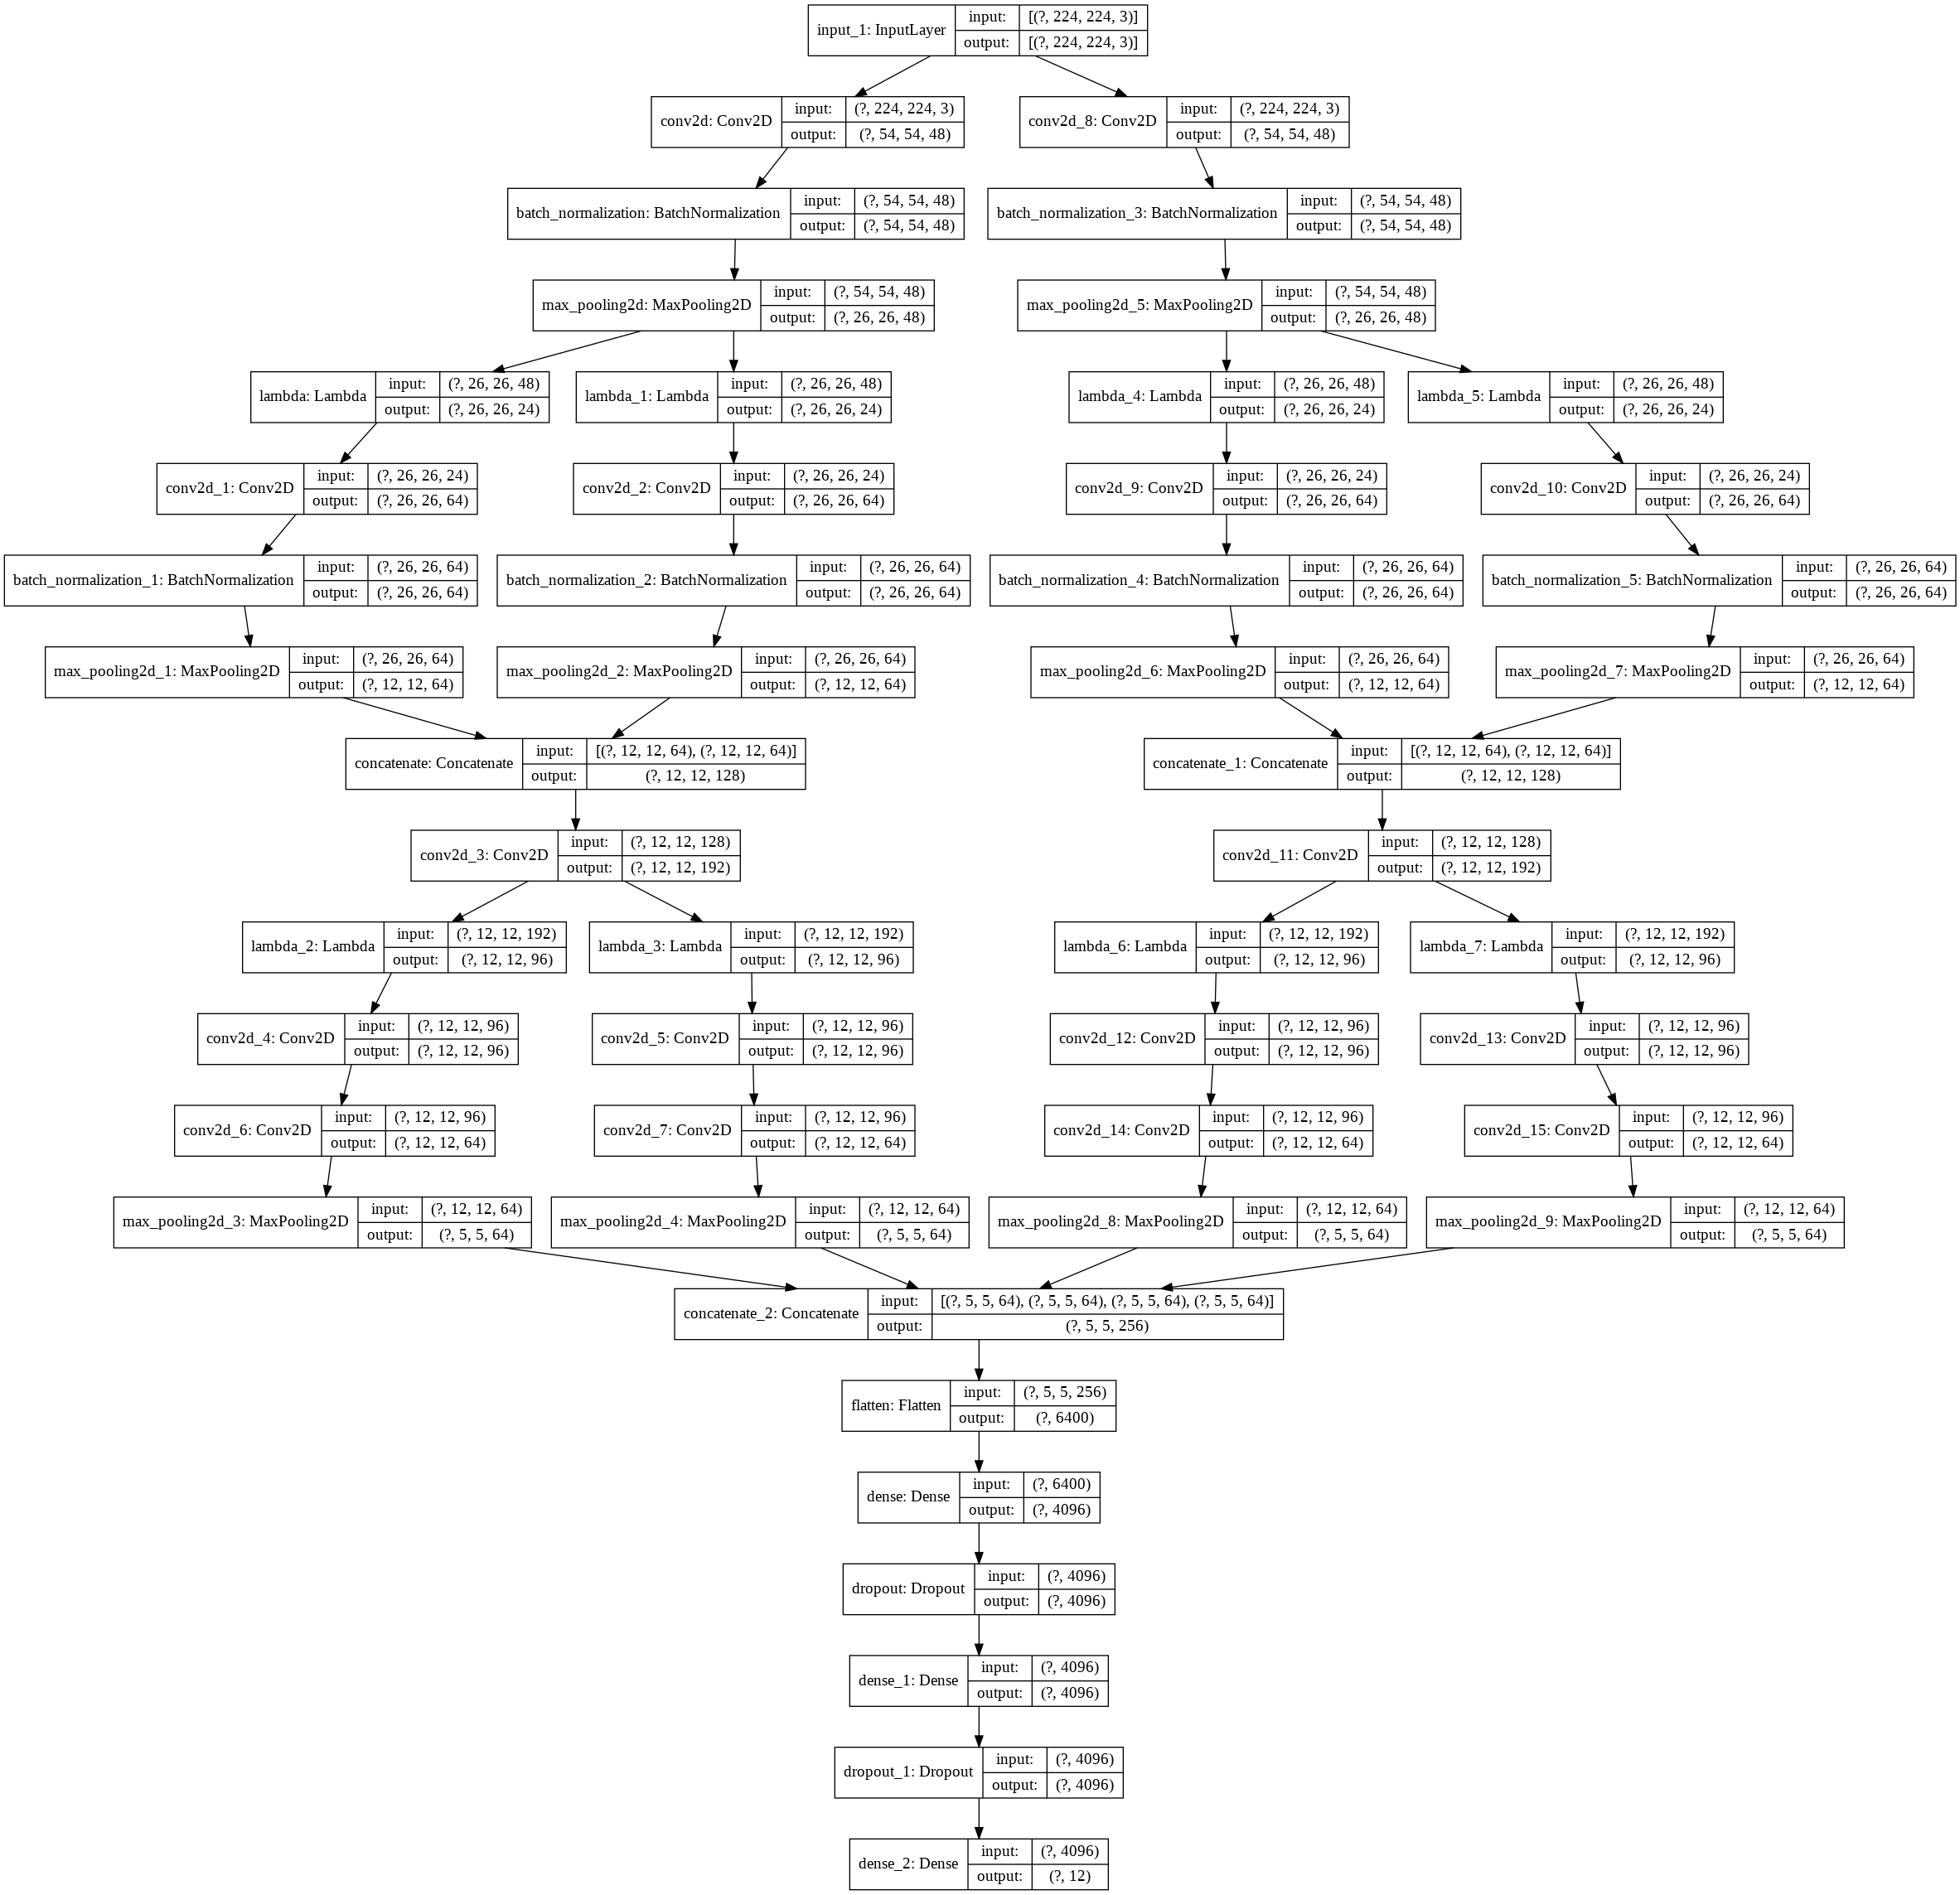

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
root_logdir = os.path.join("my_logs")

def get_run_logdir() : 
    import time 
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [ ]:
run_logdir = get_run_logdir() 

In [ ]:
img_rows , img_cols = 224, 224
num_classes = 12
batch_size = 512
nb_epoch = 100


# initialise model
model = color_net(num_classes)

filepath = 'color_weights2.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Early Stopping 
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Learning Rate Scheduling (Performance Scheduling) 
learning_rate_reduction = ReduceLROnPlateau( 
    monitor='loss', factor=0.25,  patience=2, verbose=1, mode="auto", min_delta=0.0001, cooldown=0, min_lr=0.00001)

# tensorboard_cb = TensorBoard(run_logdir)

callbacks_list = [checkpoint, early_stopping, learning_rate_reduction]


# train , test split 
train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.3,
            horizontal_flip=True, 
            validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)


# data load
training_set = train_datagen.flow_from_directory(
            'train/',
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            subset="training",
            class_mode='categorical')

validation_set = train_datagen.flow_from_directory(
            'train/',
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            subset="validation",
            class_mode='categorical')


step_train = 4996 // batch_size
step_val = 1243 // batch_size

Found 4996 images belonging to 12 classes.
Found 1243 images belonging to 12 classes.


In [ ]:
history = model.fit(
            training_set,
            steps_per_epoch=step_train,
            epochs=nb_epoch,
            validation_data=validation_set,
            validation_steps=step_val,
            callbacks=callbacks_list)

model.save('color_model2.h5')

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 3.0718 - accuracy: 0.1149 
Epoch 00001: val_accuracy improved from -inf to 0.17285, saving model to color_weights2.hdf5
9/9 [==============================] - 1413s 157s/step - loss: 3.0718 - accuracy: 0.1149 - val_loss: 2.4688 - val_accuracy: 0.1729
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 2.3328 - accuracy: 0.2252
Epoch 00002: val_accuracy did not improve from 0.17285
9/9 [==============================] - 62s 7s/step - loss: 2.3328 - accuracy: 0.2252 - val_loss: 2.4672 - val_accuracy: 0.1143
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 2.0359 - accuracy: 0.3327
Epoch 00003: val_accuracy did not improve from 0.17285
9/9 [==============================] - 62s 7s/step - loss: 2.0359 - accuracy: 0.3327 - val_loss: 2.4600 - val_accuracy: 0.1270
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 1.8254 - accuracy: 0.4068
Epoch 00004: val_accuracy did not impro

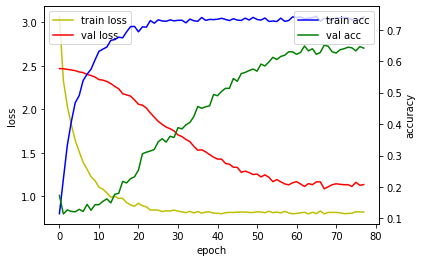

In [ ]:
# visualize model.history results
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

# train / val loss 
loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

# train / val accuracy 
acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

In [ ]:
ls

color_model2.h5  color_weights2.hdf5  model_plot.png         my_logs/  train/
color_model.h5   color_weights.hdf5   model_plot_simple.png  test/


In [ ]:
test_set = test_datagen.flow_from_directory(
            'test/',
            target_size=(img_rows, img_cols),
            batch_size=batch_size)

Found 110 images belonging to 1 classes.


In [ ]:
print("-- Predict --")
output = model.predict(test_set)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_set.class_indices)
print(output)

-- Predict --
{'unk': 0}
[[0.000 0.000 0.003 ... 0.000 0.001 0.007]
 [0.000 0.000 0.000 ... 0.000 0.000 0.982]
 [0.000 0.000 0.005 ... 0.000 0.001 0.003]
 ...
 [0.000 0.000 0.000 ... 0.000 0.000 0.000]
 [0.009 0.958 0.000 ... 0.002 0.003 0.000]
 [0.001 0.000 0.002 ... 0.001 0.004 0.000]]


In [ ]:
output.shape

(110, 12)

In [ ]:
output[0]

array([0.000, 0.000, 0.003, 0.000, 0.000, 0.846, 0.134, 0.000, 0.009,
       0.000, 0.001, 0.007], dtype=float32)

In [ ]:
training_set.class_indices

{'black': 0,
 'blue': 1,
 'brown': 2,
 'green': 3,
 'grey': 4,
 'orange': 5,
 'pink': 6,
 'purple': 7,
 'red': 8,
 'silver': 9,
 'white': 10,
 'yellow': 11}

In [ ]:
pred_prob = [np.argmax(o) for o in output]

reversed_dict = {training_set.class_indices[k]:k for k in training_set.class_indices}
pred_label = [reversed_dict[elem] for elem in pred_prob]

In [ ]:
pred_label[:10]

['orange',
 'yellow',
 'orange',
 'brown',
 'red',
 'orange',
 'red',
 'pink',
 'orange',
 'purple']

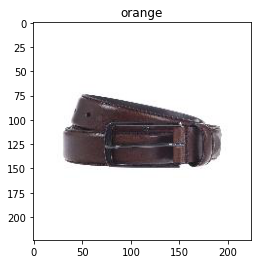

In [ ]:
plt.imshow(test_set[0][0][0])
plt.title(pred_label[0])
plt.show()

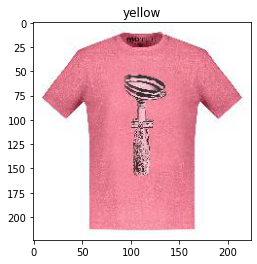

In [ ]:
plt.imshow(test_set[0][0][1])
plt.title(pred_label[1])
plt.show()

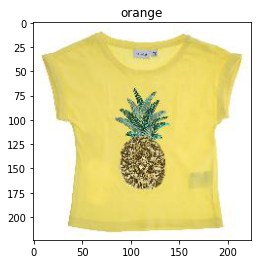

In [ ]:
plt.imshow(test_set[0][0][2])
plt.title(pred_label[2])
plt.show()

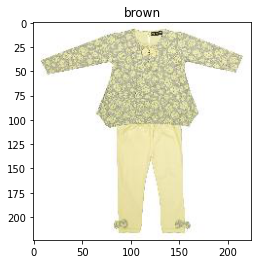

In [ ]:
plt.imshow(test_set[0][0][3])
plt.title(pred_label[3])
plt.show()

In [ ]:
random_num = np.random.choice([int(i) for i in range(100)], size=10)

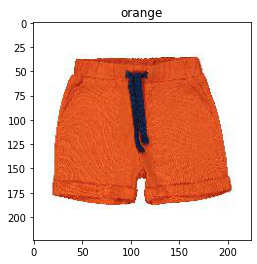

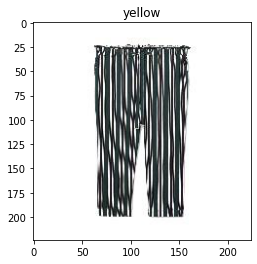

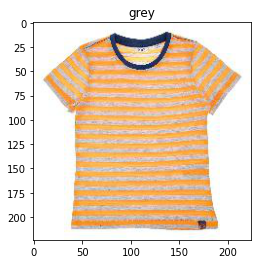

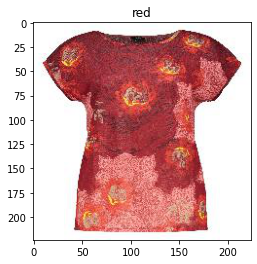

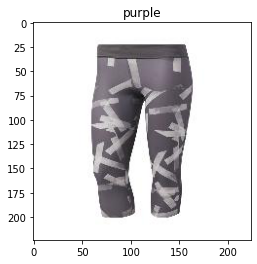

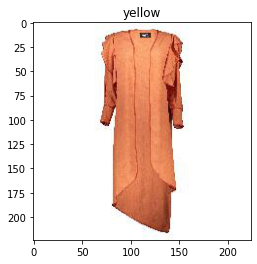

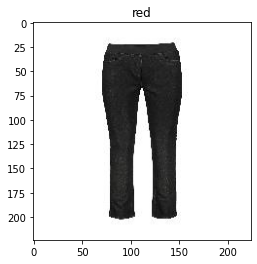

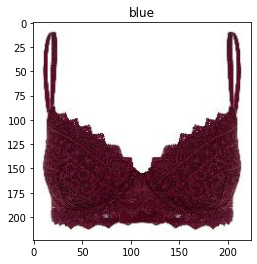

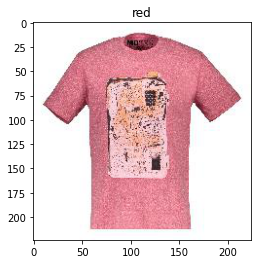

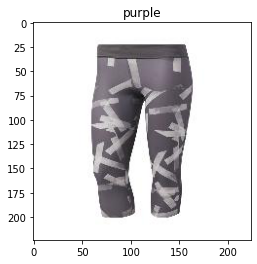

In [ ]:
for num in random_num: 
    plt.imshow(test_set[0][0][num])
    plt.title(pred_label[num])
    plt.show()